# Tutorial: Implementing cross validation

This lab focuses on how to implement cross-validation methods in R.

## Goals:
* Understand the limitations of the simple validation set approach, and the benefits of more refined approaches
* Learn to use the `cv.glm()` function to implement
    * leave-one-out cross-validation (LOOCV)
    * k-fold cross-validation (k-fold CV)
* Understand the bias-variance trade-off in the context of these resampling methods

This lab draws from the practice sets at the end of Chapter 5 in James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r." 

---
# Why not use the simple validation set approach?

Up until now, when we've wanted to "train" a model and then "test" it (such as in our demos of KNN in the previous tutorial), we've chosen a subset of the dataset to be test observations and then trained on the remainder. Although this is relatively simple and easy to implement, there are significant drawbacks.

* The validation estimate of the test error rate can be highly variable 
* Only a subset of observations (those in the training set) are used to train the model
    * This limits the statistical power, and may lead to *overestimating* test error rate 
        
Cross-validation, a reampling method used to partition your data into test and training sets, addresses both of these issues. 

Let's see how this is true.

----
# Validation data sets

Here we will explore test error rates using cross-validation. We'll be using the Auto data set again from the ISLR library. 

First, we should acknowledge that you'll need to reset the seed for your random number generator. For this use the [_set.seed()_](https://www.rdocumentation.org/packages/simEd/versions/1.0.3/topics/set.seed) function. We want to use the same seed as the book so that you get the same results.

In [ ]:
install.packages("ISLR")
library(ISLR)
library(tidyverse)
set.seed(1) #set the seed for the random number generator. resetting the seed will give different results.

train=sample(x = 392, size = 196)  # sample 196 indices from the vector 1:392

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.3
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Above we choose 196 unique random samples out of a list ranging from 1-392. These indices will identify our training set.

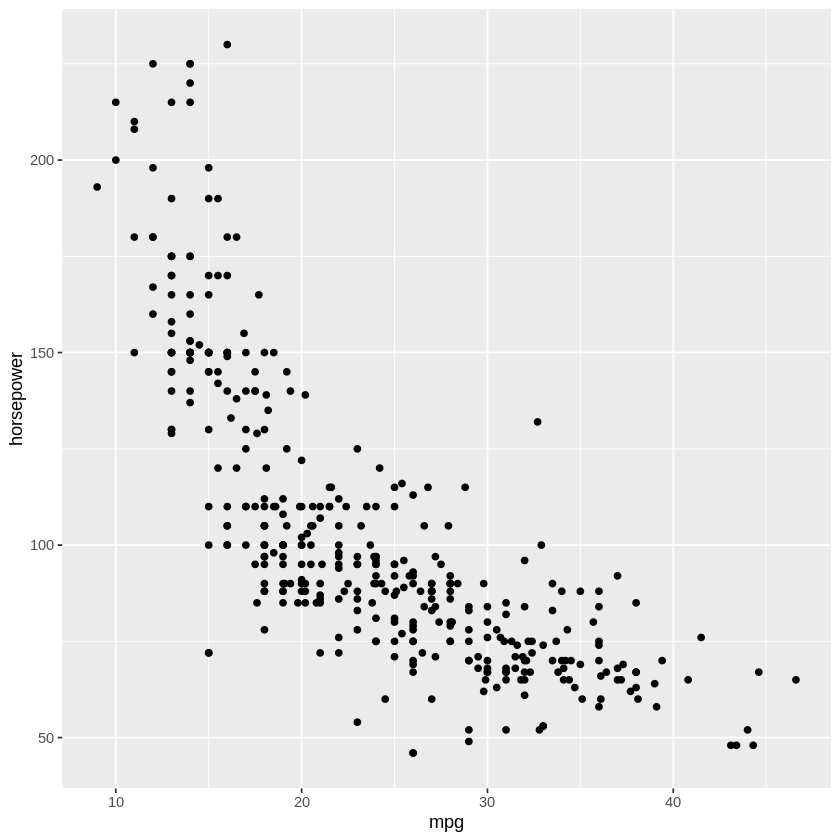

In [ ]:
ggplot(Auto,aes(mpg,horsepower)) + geom_point()

Now let's fit some models doing the training-testing approach that we've used so far in this class.

In [ ]:
# Generate a linear model using the training subset
lm.fit = lm(mpg~horsepower, data=Auto, subset=train)
mean((Auto$mpg-predict(lm.fit,Auto))[-train]^2) # Mean Squared Error (MSE) for test set

# Use the poly() function to estimate test error
# for polynomial and cubic regressions
# 2nd degree polynomial
lm.fit2 = lm(Auto$mpg~poly(horsepower,4), data=Auto, subset=train)
mean((Auto$mpg-predict(lm.fit2,Auto))[-train]^2) # Mean Squared Error (MSE) for test set

# 3rd degree polynomial
lm.fit3 = lm(Auto$mpg~poly(horsepower,6), data=Auto, subset=train)
mean((Auto$mpg-predict(lm.fit3,Auto))[-train]^2)

[1] 23.26601

[1] 19.16017

[1] 19.59465

So the MSE we observe for the linear and the two polynomial models (quadratic & cubic) is 26.14, 19.82, and 19.78 respectively. **But these exact values are sensitive to the particular subset we selected.** Let's repeat this selecting a different subset of the Auto data.

In [ ]:
# Notice that if we use a different subsample we'd get different results
set.seed(2) #using a different seed 
train=sample(392,196)

In [ ]:
# Linear model
lm.fit = lm(mpg~horsepower, data=Auto, subset=train)
mean((Auto$mpg-predict(lm.fit,Auto))[-train]^2)

# Polynomial
lm.fit2 = lm(mpg~poly(horsepower,4), data=Auto, subset=train)
mean((Auto$mpg-predict(lm.fit2,Auto))[-train]^2)

# Cubic
lm.fit3 = lm(mpg~poly(horsepower,6), data=Auto, subset=train)
mean((Auto$mpg-predict(lm.fit3,Auto))[-train]^2)

[1] 25.72651

[1] 20.30902

[1] 19.61693

This is a smaller demonstration of what is shown in figure 5.2 of James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). "An introduction to statistical learning: with applications in r.". Depending on the specific training set we use, the test error estimate can vary substantially. 

---
# Leave-one-out cross-validation (LOOCV)

Leave-one-out cross-validation (LOOCV) repeatedly splits the set of $n$ data points into a training set (blue) that has all except one observation, and a validation set that has only a single observation (beige). The test error is estimated by averaging the $n$ resulting MSEs. Below, the first training set contains everything except observation 1, the second training set contains everything except observation 2, and this continues until $n$ training sets are created and tested.


The [_boot_](https://cran.r-project.org/web/packages/boot/boot.pdf) library in R has many tools to perform LOOCV using a model fit object. Let's try performing LOOCV using the `glm()` function and the `cv.glm()` function.

We'll start with a simple linear regression model predicting `mpg` from `horsepower`, using the full data set.

In [ ]:
# Continue with the Auto example
glm.fit = glm(mpg~horsepower, data=Auto)
coef(glm.fit)

(Intercept)  horsepower 
 39.9358610  -0.1578447

Now let's use LOOCV, via the `cv.glm()` function, to estimate the cross validated MSE per the following equation.

$$ CV_{(n)} = \frac{1}{n} \sum_{i=1}^{n} MSE_i $$


In [ ]:
library(boot) # Load the bootstrap library
?cv.glm() #uncomment to get more information about this function

In [ ]:
glm.fit = glm(mpg~horsepower, data=Auto)
cv.err  = cv.glm(Auto, glm.fit, K=nrow(Auto)) #if you don't define k in the cv.glm() function, the default is LOOCV
cv.err$delta 
# ^^ note: the prediction error function for cv.glm() is MSE by default - but you can change that with "cost" variable

[1] 24.23151 24.23114

The first entry of `cv.err$delta` is the raw cross-validation estimate of prediction error (equation above) and the second is the adjusted cross-validation estimate designed to compensate for the bias introduced by not using leave-one-out cross-validation. The thing is, we *did* use leave-one-out cross-validation (`K=nrow(Auto)`), so the two values above are very close. But for smaller values of K (i.e., fewer groupings or folds over which cross-validation is run) the bias is greater and thus the error is also greater. The "corrected" value on the right estimates what the estimated MSE would be if we'd used LOOCV instead. Try changing `K` to a smaller value to see how the difference between the left and right `delta` values changes. 

*As noted in the textbook reading, there are some advantages to the bias introduced using smaller values of `K` - LOOCV isn't always the superior method.*  

Let's look at LOOCV MSE estimates for polynomial regression (this may take a minute or two to run).

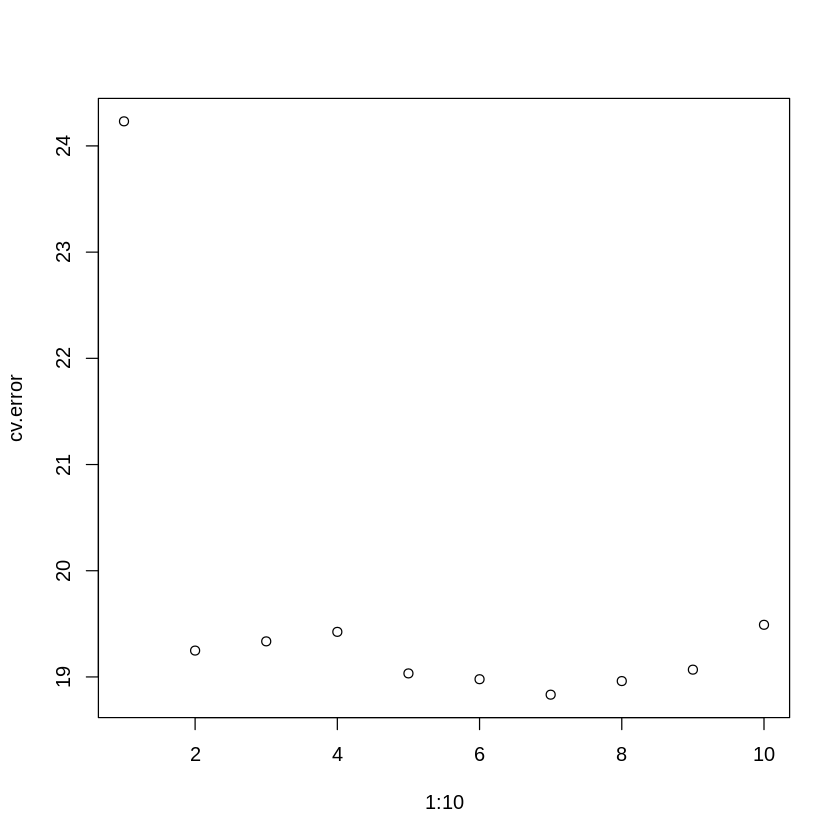

In [ ]:
# Repeat for polynomial models up to a factor of 10
cv.error = rep(0,10) # specify your output object - where you'll save the MSE estimates for each poly value
start.time <- Sys.time()
for (i in 1:10) {
    glm.fit=glm(mpg~poly(horsepower,i), data=Auto)
    cv.error[i] = cv.glm(Auto, glm.fit)$delta[1] # do LOO crossval for polynomial fits from 1 to 10
}
end.time <- Sys.time()
LOOtime <- end.time-start.time # how long did this for-loop take to run? 
plot(1:10,cv.error) # plot the error

The first entry in the `cv.error` array is the linear model we estimated above. Notice that we get an initial improvement in accuracy when you move to the 2nd order polynomial, but more complex models (i.e., higher order polynomials) only provide a modest decrease in error. This suggests it would be worth upgrading to a 2nd order polynomial model, but the benefits to increasing the complexity of our model drop off after that. This makes sense when you look at a 2nd order polynomical fit to the data (below) - adding extra bends in the curve won't improve the error much more. We can trust what the "test" error is telling us about the best model fit more because we used LOOCV instead of the simpler, set-aside-random-test-items approach.

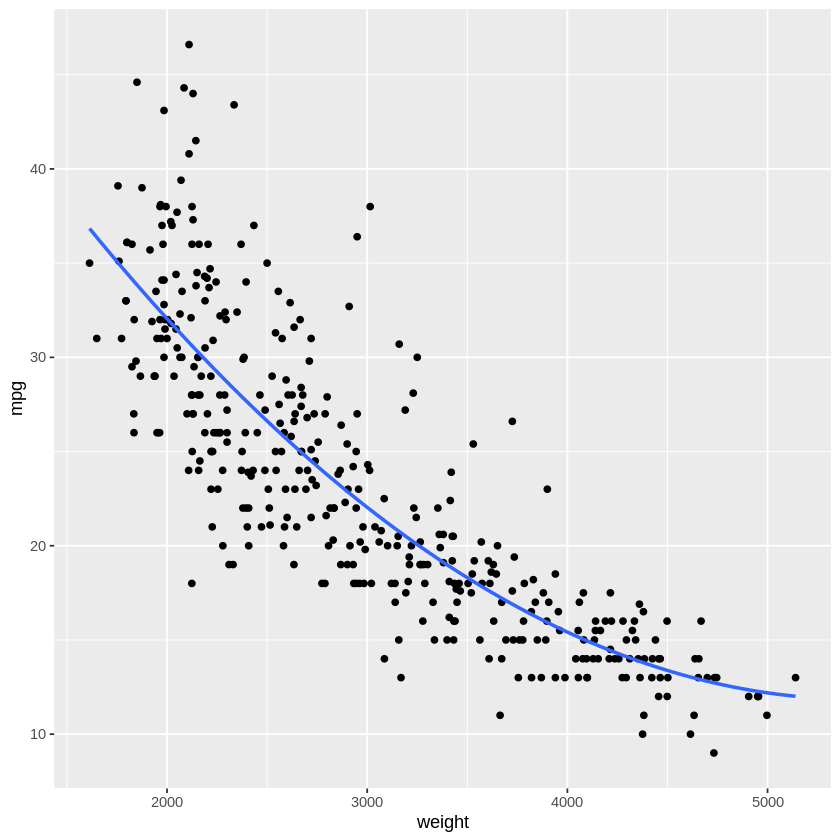

In [ ]:
ggplot(aes(weight, mpg),data=Auto) + geom_point() + stat_smooth(method = "lm", formula = y ~ poly(x,2), se = FALSE)

---
# K-fold cross validation


In 5-fold cross validation, the set of $n$ observations is randomly split into five unique groups. Each fifth of the dataset acts as a validation set, and the remainder is the training set. The average of the five resulting MSE estimates is the test error.

As stated above, the default *k* for the `cv.glm()` function is *k=n* (i.e., LOOCV). If you don't want to do LOOCV (if, for example, you have MANY observations and LOOCV would take too long) you can specify the number of folds as an input to the function.

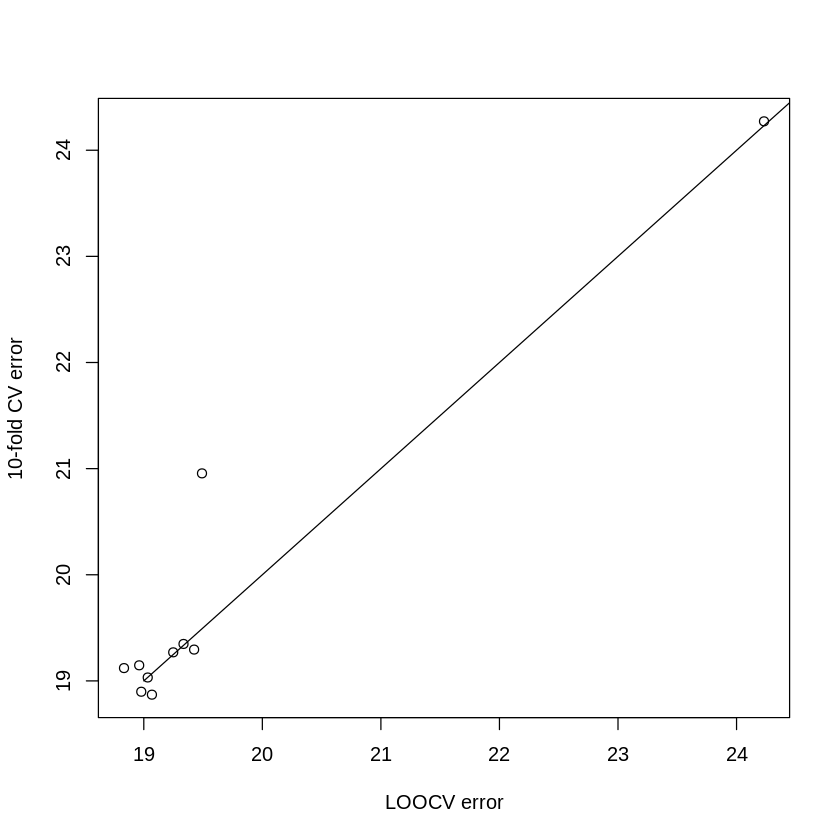

In [ ]:
# Reset the seed
set.seed(17)

# Repeat our previous loop  but use K-fold CV 
# where K = 10 and up to a 5th order polynomial
cv.error.10 = rep(0,10) # Always have to specify your output object
start.time <- Sys.time()
for (i in 1:10){
  glm.fit=glm(mpg~poly(horsepower,i), data=Auto) #get the glm fit for all 10 polynomials
  cv.error.10[i] = cv.glm(Auto, glm.fit,K=10)$delta[1]
}
end.time <- Sys.time()
Kfoldtime <- end.time-start.time # how long did this for-loop take to run?

plot(cv.error, cv.error.10, xlab="LOOCV error", ylab="10-fold CV error")
lines(c(19,25),c(19,25))


Notice how similar the results are for 10-fold CV & LOOCV. Since we measured how long the leave-one-out and 10-fold methods took to run, we can compare the run times:

In [ ]:
print(paste("Leave-one-out runtime:",LOOtime))
print(paste("10-fold runtime:",Kfoldtime))

[1] "Leave-one-out runtime: 16.6454846858978"
[1] "10-fold runtime: 0.475992202758789"


As you can see, 10-fold was much quicker to run.

*Notebook authored by Ven Popov and edited by Krista Bond, Charles Wu, Patience Stevens, and Amy Sentis.*